In [304]:
import numpy as np
import matplotlib.pyplot as plt

In [338]:
class SHE():
    def __init__(self, N = 1000, g  =1 , u = 0.25 , T = 0.5, CFL = 0.5):
        self.N = N
        self.g = g
        self.dx = 2/(N)
        self.k = None
        self.u = u
        self.bc = None
        h = np.zeros(N+1)
        m = np.zeros(N+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N+1)
        self.CFL = 0.5
        self.T = T
        self.t = 0
        self.h0 = None

    def update_k(self):
        u = self.q[1] / self.q[0]
        self.k = self.CFL * self.dx / (np.max(np.abs(u) + np.sqrt(self.g*self.q[0])))

    
    def IV(self , h:callable , m:callable):
        self.h0 = h
        self.q[0] = h(self.x)
        self.q[1] = m(self.x)

    def f(self , u):
        #print(f"u_1 is {u[0],u[1]}")
        return np.array([u[1], ((u[1]**2)/u[0]) + 0.5*self.g*(u[0]**2)])
    
    def F(self , u,v):
        #print(u.shape)
        #print(self.f(u) + self.f(v))
        #print(np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.k / self.dx)*(v - u)))
        return np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.dx / self.k)*(v - u))
    
    def S(self, x_val):
        s1 = np.pi/2 * (self.u-1) * np.cos(np.pi*(x_val-self.t))
        s2 = np.pi/2 * np.cos(np.pi*(x_val-self.t)) * (-self.u+(self.u**2)+self.g*self.h0(x_val-self.t))
        #print(s1,s2)
        return np.array([s1, s2])

    def set_BC(self , bc):
        self.bc = bc

    def Solve(self):
        self.t=0

        if self.bc=="P":
            while self.t < self.T:
                #print(self.t)

                #print(f"Hi, from time {self.t} with {self.q[0,0]}")
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t
                

                q_old = self.q.copy()

                for j in range(self.N+1):

                    flux_term = self.F(q_old[:,j] , q_old[:,(j+1) % self.N]) - self.F(q_old[:, (j-1) % self.N] , q_old[:,j])
                    #print(flux_term)
                    #print(flux_term.shape)
                    #print(self.q[:,j])
                    #print(q_old[:,j])
                    y = self.S(self.dx * j)
                    #print(y)
                    #print(self.S(self.dx * j))

                    self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    #break
                    
                
                self.t += self.k
                #break
                

        elif self.bc=="O":
            self.update_k()

            if self.t + self.k > self.T:
                self.k = self.T - self.t
                
            self.t += self.k
            q_old = self.q.copy()
            for j in range(1 , self.N):
                flux_term = self.F(q_old[:,j] , q_old[:,(j+1)]) - self.F(q_old[:, (j-1)] , q_old[:,j])
                self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term #+ self.k * self.S(self.dx * j)
            

In [339]:
### Implementing all the initial values:

#A
def h0_A(x):
    return 1 + 0.5*np.sin(np.pi * x)

def m0_A(x , u = 0.25):
    return u * h0_A(x)
    
#B
def h0_B(x):
    return 1 - 0.1*np.sin(np.pi * x)

def m0_B(x , u = 0.25):
    return 0


#C
def h0_C(x):
    return 1 - 0.2*np.sin(2 * np.pi * x)

def m0_C(x , u = 0.25):
    return 0.5

#D
def h0_D(x):
    return 1

def m0_D(x , u = 0.25):
    return np.piecewise(x, [x < 1, x>1], [lambda x: -1.5, lambda x: 0])

In [340]:
# Define Problem
time = 0.5
Problem = SHE(T = time)

# Set Bc
Problem.set_BC("P")

#
Problem.IV(h0_A , m0_A)

In [341]:
#Problem.F(Problem.q[:,0] , Problem.q[:,0])
Problem.f(Problem.q[:,0])

array([0.25  , 0.5625])

In [342]:
Problem.Solve()

In [343]:
def h_exact(x , t) : 
    #return 1 - 0.1*np.sin(np.pi*(x - t))
    return 1+ 0.5*np.sin(np.pi*(x - t))
def m_exact(x,t):
    #return np.zeros_like(x)
    return 0.25 * h_exact(x , t)

0.5037419917864223 0.5037826105789894


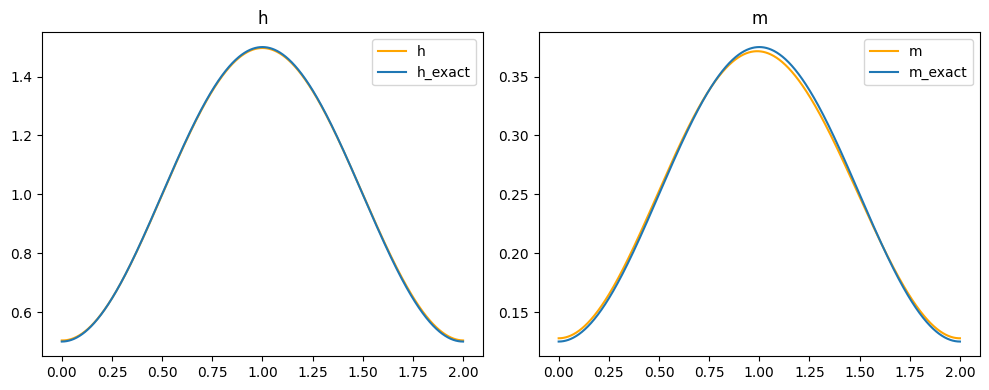

In [344]:
h = Problem.q[0]
m = Problem.q[1]

print(h[0], h[Problem.N-1])
x = Problem.x
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Plot data on the first subplot
axs[0].plot(x, h, label='h' , color = "orange")
axs[0].plot(x, h_exact(x , time), label='h_exact')
axs[0].set_title('h')
axs[0].legend()

# Plot data on the second subplot
axs[1].plot(x, m, label='m', color='orange')
axs[1].plot(x, m_exact(x , time), label='m_exact')
axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()